In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

import sys
sys.path.append('/content/gdrive/My Drive/SHREC_JHMDB-master/DD-Net-master/SHREC/')


Mounted at /content/gdrive/


In [2]:
import numpy as np
import math
import random
import pandas as pd
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"


import matplotlib.pyplot as plt
import cv2
import glob
import gc
from tqdm import tqdm
import pickle
from keras.models import load_model
from utils import *
from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.enable_eager_execution()

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, SpatialDropout1D
from keras.layers import LSTM, SimpleRNN, GRU
from keras.regularizers import l2
from keras.constraints import maxnorm
from keras.datasets import imdb

import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Instructions for updating:
non-resource variables are not supported in the long term
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



In [ ]:
class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 12 # the number of joints
        self.joint_n = 22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 16
        self.data_dir = '/content/gdrive/My Drive/SHREC_JHMDB-master/DD-Net-master/data/SHREC/'
C = Config()

Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

In [ ]:
X_0 = []
X_1 = []
X_2 =[]
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)
    M_cos = get_CG_cosine(p,C)

    X_0.append(M)
    X_1.append(M_cos)
    X_2.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1)
X_2 = np.stack(X_2)
Y = np.stack(Y)

100%|██████████| 1960/1960 [00:16<00:00, 115.63it/s]


In [ ]:
X_test_0 = []
X_test_1 = []
X_test_2 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)
    M_cos = get_CG_cosine(p,C)

    X_test_0.append(M)
    X_test_1.append(M_cos)
    X_test_2.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1) 
X_test_2 = np.stack(X_test_2)
Y_test = np.stack(Y_test)

100%|██████████| 840/840 [00:07<00:00, 117.96it/s]


In [ ]:
x_train = X_2
x_test = X_test_2
y_train =[np.where(r==1)[0][0] for r in Y]
y_test =[np.where(r==1)[0][0] for r in Y_test]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [ ]:
itd = 13

input_bottleneck = Input(shape=(itd,), name="inp_bt")
input_img = Input(shape=(2112,), name="inp_img")
input_S = Input(shape=(itd,), name="inp_S")


encoded = Dense(512, activation='relu')(input_img)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.1)(encoded)

encoded = Dense(256, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.1)(encoded)

encoded = Dense(128, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.1)(encoded)

encoded = Dense(64, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.1)(encoded)

encoded = Dense(32, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.1)(encoded)

bottlenek = Dense(itd, activation='relu', name="bottleneck")(encoded)

decoded = Dense(32, activation='relu')(bottlenek)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.1)(decoded)

decoded = Dense(64, activation='relu')(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.1)(decoded)

decoded = Dense(128, activation='relu')(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.1)(decoded)

decoded = Dense(256, activation='relu')(decoded)
decoded = Dropout(0.1)(decoded)

decoded = Dense(512, activation='relu')(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.1)(decoded)

output = Dense(2112, activation='sigmoid', name="logits")(decoded)

autoencoder = Model(input_img, output)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

In [ ]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp_img (InputLayer)         [(None, 2112)]            0         
_________________________________________________________________
dense (Dense)                (None, 512)               1081856   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)              

In [ ]:
autoencoder.fit(x_train, x_train,epochs=500)

Epoch 1/500
62/62 [==============================] - 2s 28ms/step - loss: 0.2709
Epoch 2/500
62/62 [==============================] - 2s 28ms/step - loss: 0.2709
Epoch 3/500
62/62 [==============================] - 2s 27ms/step - loss: 0.2709
Epoch 4/500
62/62 [==============================] - 2s 27ms/step - loss: 0.2709
Epoch 5/500
62/62 [==============================] - 2s 27ms/step - loss: 0.2709
Epoch 6/500
62/62 [==============================] - 2s 27ms/step - loss: 0.2709
Epoch 7/500
62/62 [==============================] - 2s 28ms/step - loss: 0.2710
Epoch 8/500
62/62 [==============================] - 2s 28ms/step - loss: 0.2709
Epoch 9/500
62/62 [==============================] - 2s 28ms/step - loss: 0.2709
Epoch 10/500
62/62 [==============================] - 2s 28ms/step - loss: 0.2709
Epoch 11/500
62/62 [==============================] - 2s 29ms/step - loss: 0.2709
Epoch 12/500
62/62 [==============================] - 2s 28ms/step - loss: 0.2709
Epoch 13/500
62/62 [=====

In [ ]:
bottleneck_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("bottleneck").output)

In [ ]:
latent_space = bottleneck_model.predict(x_train)

In [ ]:
x_train2 =  bottleneck_model.predict(x_train)
x_test2 = bottleneck_model.predict(x_test)

In [ ]:
print(x_train2.shape)
print(x_test2.shape)

(1960, 13)
(840, 13)


In [ ]:
import time
from sklearn.manifold import TSNE

new = x_train2
N = 1960
df_subset = new
data_subset =new

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(new)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1960 samples in 0.005s...
[t-SNE] Computed neighbors for 1960 samples in 0.108s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1960
[t-SNE] Computed conditional probabilities for sample 1960 / 1960
[t-SNE] Mean sigma: 0.375387
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.035103
[t-SNE] KL divergence after 300 iterations: 2.006532
t-SNE done! Time elapsed: 4.27384614944458 seconds


In [ ]:
# Utility function to visualize the outputs of PCA and t-SNE

def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=32)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 576x576 with 1 Axes>,
 [Text(0.085459135, -8.409981, '0'),
  Text(1.3874899, -5.0223813, '1'),
  Text(-1.1195887, -3.788982, '2'),
  Text(5.2343135, -4.472528, '3'),
  Text(-2.5362768, 0.7314506, '4'),
  Text(-0.47750986, 1.7981659, '5'),
  Text(-15.569778, 1.4007609, '6'),
  Text(4.199133, 4.119795, '7'),
  Text(-12.364113, 8.453296, '8'),
  Text(2.199427, -1.113377, '9'),
  Text(13.042107, 8.95796, '10'),
  Text(12.668499, 9.1407795, '11'),
  Text(-12.201115, -2.0606103, '12'),
  Text(1.1020133, -1.3184706, '13')])

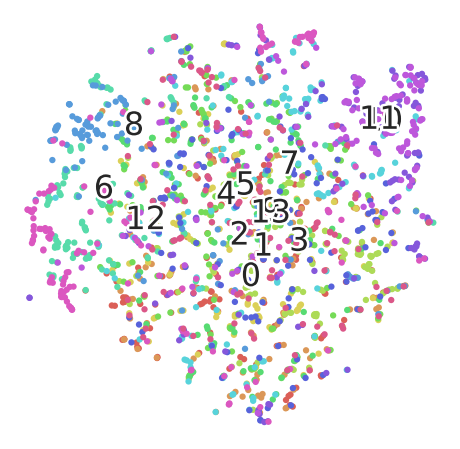

In [ ]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123

tsne_results =  np.array(tsne_results, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
fashion_scatter(tsne_results, y_train)